# 1. 패키지 로드

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from PIL import Image
from tqdm import tqdm
import time
import gc
import random
from box import Box
import cv2
import cvlib as cv
import timm

import warnings
warnings.filterwarnings('ignore')

2022-02-28 12:54:50.125060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-02-28 12:54:50.125093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. 학습 관련 함수

## 2-1. seed 고정

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## 2-2. 데이터 전처리

In [3]:
# ages 생성
def get_ages(x):
    if x < 30: return 0
    elif x < 60: return 1
    else: return 2

# genders 생성
def get_genders(x):
    if x == 'male': return 0
    else: return 1

# masks 생성
def get_masks(x):
    if x == 'normal': return 2
    elif x == 'incorrect_mask': return 1
    else: return 0

# # age_cats 생성
# def get_age_cats(x):
#     if x < 20: return 0
#     elif x < 30: return 1
#     elif x < 40: return 2
#     elif x < 50: return 3
#     elif x < 60: return 4
#     else: return 5

def get_age_cats(x):
    if x < 25: return 0
    elif x < 30: return 1
    elif x < 45: return 2
    elif x < 52: return 3
    elif x < 57: return 4
    elif x < 60: return 5
    else: return 6

# labels 생성
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

# label_cats 생성
def get_label_cats(masks, genders, ages):
    return masks * 12 + genders * 6 + ages

# 마스크 이상치 변경
def swap_mask(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap_id in swap_li:
        _swap_df = swap_df[swap_df['id'] == swap_id]
        
        normal_swap_df = _swap_df[_swap_df['mask'] == 'normal']
        incorrect_mask_swap_df = _swap_df[_swap_df['mask'] == 'incorrect_mask']
        
        normal_path = normal_swap_df['path'].values[0]
        incorrect_mask_path = incorrect_mask_swap_df['path'].values[0]
        
        swap_df.loc[normal_swap_df.index, 'path'] = incorrect_mask_path
        swap_df.loc[incorrect_mask_swap_df.index, 'path'] = normal_path
    
    return swap_df

# train_df + mask 결측치 처리
def make_train_df(df : pd.DataFrame, swap_mask_li : list, cfg) -> pd.DataFrame:
    train_df = []
    
    for line in df.iloc:
        for file in list(os.listdir(os.path.join(cfg.train_image_dir, line['path']))):
            if file[0] == '.':
                continue
            
            mask = file.split('.')[0]
            gender = line['gender']
            age = line['age']
            
            masks = get_masks(mask)
            genders = get_genders(gender)
            ages = get_ages(age)
            age_cats = get_age_cats(age)
            
            data = {
                'id' : line['id'],
                'mask' : mask,
                'gender' : gender,
                'age' : age,
                'masks' : masks,
                'genders' : genders,
                'ages' : ages,
                'age_cats' : age_cats,
                'labels': get_labels(masks = masks, genders = genders, ages = ages),
                'label_cats': get_label_cats(masks = masks, genders = genders, ages = age_cats),
                'path': os.path.join(cfg.train_image_dir, line['path'], file),
            }
            
            train_df.append(data)
            
    train_df = pd.DataFrame(train_df)
    
    train_df['idx'] = train_df.index
    
    train_df = swap_mask(swap_li = swap_mask_li, df = train_df)
    
    return train_df

# 성별 이상치 처리
def swap_gender(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap in swap_li:
        swap_id, swap_gender = swap
        swap_df.loc[swap_df[swap_df['id'] == swap_id].index, 'gender'] = swap_gender
    return swap_df

# 사람 나누기 데이터 + 성별 결측치 처리
def preprocessing_df(df : pd.DataFrame, swap_gender_li : list) -> pd.DataFrame:
    
    preprocessing_df = df.copy()
    preprocessing_df = swap_gender(swap_li = swap_gender_li, df = preprocessing_df)
    
    preprocessing_df['ages'] = preprocessing_df['age'].apply(lambda x : get_ages(x))
    preprocessing_df['genders'] = preprocessing_df['gender'].apply(lambda x : get_genders(x))
    
    preprocessing_df['cv_taget_col'] = 'ages' + '_' + preprocessing_df['ages'].astype(str) + '_' + 'genders' + '_' + preprocessing_df['genders'].astype(str)
    
    return preprocessing_df

## 2-3 이상치 시각화

In [4]:
# 이상치 이미지 시각화
def show_img(img_id_li, df, cfg):
    for img_id in img_id_li:
        get_df = df[df['id'] == img_id]
        
        img_age = get_df['age'].tolist()[0]
        img_gender = get_df['gender'].tolist()[0]
        
        img_path = get_df['path'].tolist()[0]
        img_path = os.path.join(cfg.train_image_dir, img_path)
        img_name_li = sorted(list(os.listdir(img_path)))
        
        fig, ax = plt.subplots(1, 7, figsize = (30, 15))
        ax = ax.flatten()
        
        idx = 0
        for _img_name in img_name_li:
            if _img_name[0] == '.': continue
            
            if _img_name.split('.')[0] == 'normal': imag_name = 'normal'
            elif _img_name.split('.')[0] == 'incorrect_mask': imag_name = 'incorrect_mask'
            else: imag_name = 'mask'
            
            get_img_path = os.path.join(img_path, _img_name)
            
            img = Image.open(get_img_path)
            img = np.array(img)
            ax[idx].imshow(img)
            ax[idx].set_title(f'{img_id} / {img_age} / {img_gender} / {imag_name}')
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            idx += 1
            
        plt.show()

# image path로 이미지 시각화
def path_li_show_img(path_li):
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    idx = 0
    for path in path_li:
        image_name = path.split('/')[-1]
        img = Image.open(path)
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'{image_name}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

## 2-4. 데이터 스플릿

In [5]:
# val_idx 생성
def get_val_idx(df : pd.DataFrame, target_col : str):
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)
    for trn_idx, val_idx in skf.split(df, df[target_col]):
        yield val_idx

class StratifiedSampler(torch.utils.data.Sampler):
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.cpu().numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits = n_batches, shuffle = shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

## 2-5. 모델 관련

In [6]:
class CreateModel(nn.Module):
    def __init__(self, cfg , pretrained : bool = True):
        super(CreateModel, self).__init__()
        self.model = timm.create_model(cfg.timm_model_name, pretrained = pretrained, num_classes = cfg.num_classes)

    def forward(self, img):
        out = self.model(img)
        return out

In [7]:
def model_train(model, optimizer, criterion, data_loader):
    model.train()
    
    train_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # GA 추가시 아래 부분에 추가하기
        #############################
        
        benign_outputs = model(images)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        predicted = benign_outputs.argmax(dim=-1)
        
        label_pred_li.extend(predicted.detach().cpu().numpy())
        real_pred_li.extend(targets.cpu().numpy())
        
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    train_loss /= len(data_loader)
    train_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    train_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)

    return train_loss, train_acc, train_fi_score

def model_eval(model, criterion, data_loader):
    model.eval()
    
    val_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)

            benign_outputs = model(images)
            loss = criterion(benign_outputs, targets)

            val_loss += loss.item()

            predicted = benign_outputs.argmax(dim=-1)
        
            label_pred_li.extend(predicted.cpu().numpy())
            real_pred_li.extend(targets.cpu().numpy())
    
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    val_loss /= len(data_loader)
    val_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    val_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)
   
    return val_loss, val_acc, val_fi_score

def get_val_pred_li(model, data_loader):
    model.eval()
    real_pred_li = []
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
            real_pred_li.extend(targets.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li), real_pred_li

def get_submission_pred_li(model, data_loader):
    model.eval()
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li)

## 2-6. 평가

In [8]:
def get_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def get_acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## 2-7. 로스

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

# 3. 학습 환경 설정

## 3-1. config

In [10]:
v = 1
config = {
    'seed' : 22,
    'data_split_col' : 'cv_taget_col',
    'oof' : 5,
    
    'train_data_name' : 'train.csv',
    'train_data_dir' : '/opt/ml/input/data/train',
    'train_image_dir' : '/opt/ml/input/data/train/images',
    
    'submission_data_name' : 'info.csv',
    'submission_data_dir' : '/opt/ml/input/data/eval',
    'submission_image_dir' : '/opt/ml/input/data/eval/images',
    
    'file_name' : f'Ensembel_v{v}.csv',
    
    'maskModel':{
        
        'tagets_col' : 'masks',
        'split_col' : 'masks',
        
        'timm_model_name' : 'regnety_002',
        
        'model_dir' : '/opt/ml/model',
        'model_name' : f'mask_model_v{v}',
        'num_workers' : 3,
        'epochs' : 1,
        'batch_size' : 128,
        'lr' : 9e-05,
        'num_classes' : 3,
        
        'loss' : 'cel',
        'smoothing' : 0.1,
        
        'image_size' : [50, 50],
        'image_normal_mean' : [0.5, 0.5, 0.5],
        'image_normal_std' : [0.2, 0.2, 0.2],
        
    },
    
    'genderModel':{
        
        'tagets_col' : 'genders',
        'split_col' : 'genders',
        
        'timm_model_name' : 'regnety_002',
        
        'model_dir' : '/opt/ml/model',
        'model_name' : f'gender_model_v{v}',
        'num_workers' : 3,
        'epochs' : 1,
        'batch_size' : 128,
        'lr' : 9e-05,
        'num_classes' : 2,
        
        'loss' : 'cel',
        'smoothing' : 0.1,
        
        'image_size' : [50, 50],
        'image_normal_mean' : [0.5, 0.5, 0.5],
        'image_normal_std' : [0.2, 0.2, 0.2],
        
    },
    
    'ageModel':{
        
        'tagets_col' : 'ages',
        'split_col' : 'ages',
        
        'timm_model_name' : 'regnety_002',
        
        'model_dir' : '/opt/ml/model',
        'model_name' : f'age_model_v{v}',
        'num_workers' : 3,
        'epochs' : 1,
        'batch_size' : 128,
        'lr' : 9e-05,
        'num_classes' : 3,
        
        'loss' : 'labelsmoothing',
        'smoothing' : 0.1,
        
        'image_size' : [50, 50],
        'image_normal_mean' : [0.5, 0.5, 0.5],
        'image_normal_std' : [0.2, 0.2, 0.2],
        
    },
    
}

config = Box(config)

## 3-2 이미지

In [11]:
# 변환할 transform
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, Lambda, RandomHorizontalFlip, ToPILImage, CenterCrop, Grayscale

def image_face_crop(image):
    image = np.array(image)
    face, confidence = cv.detect_face(image)
    if not face : return image
    x, y, w, h = face[0]
    H, W, C = image.shape
    image = image[max(y - 100, 0) : min(h + 100, H), max(0 , x - 100) : min(w + 100, W)]
    return image

transform = {
        "maskModel": transforms.Compose(
            [
                Resize(config.maskModel.image_size, Image.BILINEAR),
                ToTensor(),
                Normalize(mean=config.maskModel.image_normal_mean, std=config.maskModel.image_normal_std),
                Grayscale(num_output_channels = 3)
            ]
        ),
        "genderModel": transforms.Compose(
            [
                Resize(config.genderModel.image_size, Image.BILINEAR),
                ToTensor(),
                Normalize(mean=config.genderModel.image_normal_mean, std=config.genderModel.image_normal_std),
                Grayscale(num_output_channels = 3)
            ]
        ),
        "ageModel": transforms.Compose(
            [
                Resize(config.ageModel.image_size, Image.BILINEAR),
                ToTensor(),
                Normalize(mean=config.ageModel.image_normal_mean, std=config.ageModel.image_normal_std),
                Grayscale(num_output_channels = 3)
            ]
        ),
    
}

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cfg, transform = None, mode : bool = True, mode_type = None, arg_transform = None):
        self.mode = mode
        self.df = df
        self.mode_type = mode_type
        if self.mode:
            if self.mode_type =='arg':
                self.img_paths = self.df['path'].tolist()
                self.targets = self.df[cfg.tagets_col].tolist()
                self.split_targets = self.df[cfg.split_col].tolist()
                self.arg_cols = self.df['arg_types'].tolist()
            else:
                self.img_paths = self.df['path'].tolist()
                self.targets = self.df[cfg.tagets_col].tolist()
                self.split_targets = self.df[cfg.split_col].tolist()
        else:
            self.img_paths = [os.path.join(cfg.submission_image_dir, img_id) for img_id in self.df.ImageID]
        self.transform = transform
        self.arg_transform = arg_transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        if self.mode_type =='arg':
            if self.arg_cols[index] == 0:
                image = self.transform(image)
            else:
                image = self.arg_transform(image)
        else:
            if self.transform:
                image = self.transform(image)
        
        # 이 부분에 해당 라벨에 따른 데이터 변환 여부 추가
        # val 데이터의 경우 데이터 변환이 일어나면 안되기 때문에
        # if self.데이터 변환해주는 transform:
        #     if self.targets[index].data == labels: <- 확률적으로
        #          image = self.데이터 변환해주는 transform(image)
        # 데이터 변환
        
        if self.mode:
            targets = torch.tensor(self.targets[index])
            return image, targets
        
        else: return image

    def __len__(self):
        return len(self.img_paths)

In [29]:
def get_trn_val_dataset_dataloader(trn_df : pd.DataFrame, val_df : pd.DataFrame, cfg, model_name : str):
    
    trn_dataset = CustomDataset(df = trn_df,
                            cfg = cfg,
                            transform = transform[model_name],
                            mode = True,
                           )
    
    train_loader = DataLoader(trn_dataset,
                       batch_size = cfg.batch_size,
                       num_workers = cfg.num_workers,
                       shuffle = True,
                        )

    val_dataset = CustomDataset(df = val_df,
                            cfg = cfg,
                            transform = transform[model_name],
                            mode = True,)

    val_loader = DataLoader(val_dataset,
                       batch_size = cfg.batch_size,
                       num_workers = cfg.num_workers,
                       shuffle = False,)

    return trn_dataset, train_loader, val_dataset, val_loader

def get_criterion(config):
    # loss 설정
    if config.loss == 'cel':
        criterion = nn.CrossEntropyLoss()
    elif config.loss == 'labelsmoothing':
        criterion = LabelSmoothingLoss(classes=config.num_classes, smoothing = config.smoothing, dim=-1)
    elif config.loss == 'focal':
        criterion = FocalLoss(weight = config.weight, gamma=2.0, reduction='mean')
    elif config.loss == 'f1':
        criterion = F1Loss(classes=config.num_classes, epsilon=1e-7)
    else:
        print('not loss')
    return criterion

def train(model, optimizer, criterion, train_loader, val_loader, scheduler, config, version = ''):
    besf_f1 = 0
    for epoch in range(1, config.epochs + 1):
        epoch_start_time = time.time()

        train_loss, train_acc, train_fi_score = model_train(model = model, 
                                                        optimizer = optimizer, 
                                                        criterion = criterion, 
                                                        data_loader = train_loader)

        val_loss, val_acc, val_fi_score, = model_eval(model = model,
                                                  criterion = criterion,
                                                  data_loader = val_loader)

        now_lr = get_lr(optimizer = optimizer)

        epoch_end_time = time.time()

        print(f'''{fold_num}fold, epoch: {epoch}, lr: {now_lr}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, train_f1: {train_fi_score:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_fi: {val_fi_score:.4f}, 학습시간: {epoch_end_time - epoch_start_time} \n''')

        scheduler.step(val_loss)

        if besf_f1 < val_fi_score:
            besf_f1 = val_fi_score
            torch.save(model.state_dict(), os.path.join(config.model_dir, f'{version}_{fold_num}fold_{config.model_name}.pt'))
            print(val_fi_score, '모델 저장')
            
def get_eval_img_show(train_df, idx_li, pred_labels, config):
    image_show_df = train_df.set_index('idx').loc[idx_li, :].reset_index(drop = True)
    image_show_df['pred_labels'] = pred_labels
    false_image_show_df = image_show_df[image_show_df[config.tagets_col] != image_show_df['pred_labels']]
    labels_li = [i for i in range(config.num_classes)]
    
    for labels in labels_li:
        _false_image_show_df = false_image_show_df[false_image_show_df[config.tagets_col] == labels]
        path_labels_pred_labels_li = _false_image_show_df[['path', config.tagets_col, 'pred_labels']].values[:7]

        idx = 0
        fig, ax = plt.subplots(1, 7, figsize = (30, 15))
        ax = ax.flatten()
        for path_labels_pred_labels in path_labels_pred_labels_li:
            img = Image.open(path_labels_pred_labels[0])
            img = np.array(img)
            ax[idx].imshow(img)
            ax[idx].set_title(f'true {path_labels_pred_labels[1]} / pred {path_labels_pred_labels[2]}')
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            idx += 1
        plt.show()

# 4. 데이터 로드 

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
swap_gender_li = [["001498-1", "female"], ["004432", "female"],["005223", "female"], 
                  ['006359', 'male'], ['006360', 'male'], ['006361', 'male'], ['006362', 'male'], ['006363', 'male'], ['006364', 'male'],]
swap_mask_li = ['000020', '004418', '005227']

In [16]:
seed_everything(config.seed)

In [17]:
df = pd.read_csv(os.path.join(config.train_data_dir, config.train_data_name))
submission = pd.read_csv(os.path.join(config.submission_data_dir, config.submission_data_name))
submission['idx'] = submission.index

# 5. Mask Model

In [31]:
version = 'mask'

In [19]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index(drop = True)
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.maskModel, 
                                                                                        model_name = 'maskModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.maskModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.maskModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.maskModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.maskModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 9e-05, train_loss: 0.7727, train_acc: 0.6830, train_f1: 0.3439, val_loss: 0.6348, val_acc: 0.7473, val_fi: 0.4338, 학습시간: 28.253862857818604 

0.43381196432332164 모델 저장
1fold 훈련 시간: 32.70211434364319 

2fold, epoch: 1, lr: 9e-05, train_loss: 0.7715, train_acc: 0.6852, train_f1: 0.3371, val_loss: 0.6364, val_acc: 0.7463, val_fi: 0.4334, 학습시간: 28.359328746795654 

0.43339861098610166 모델 저장
2fold 훈련 시간: 28.65281629562378 

3fold, epoch: 1, lr: 9e-05, train_loss: 0.7849, train_acc: 0.6766, train_f1: 0.3388, val_loss: 0.6337, val_acc: 0.7458, val_fi: 0.4127, 학습시간: 28.289815664291382 

0.41268327621405226 모델 저장
3fold 훈련 시간: 28.56338405609131 

4fold, epoch: 1, lr: 9e-05, train_loss: 0.7462, train_acc: 0.7105, train_f1: 0.3420, val_loss: 0.6170, val_acc: 0.7592, val_fi: 0.4542, 학습시간: 28.355239152908325 

0.45422783742584905 모델 저장
4fold 훈련 시간: 28.640215396881104 

5fold, epoch: 1, lr: 9e-05, train_loss: 0.7441, train_acc: 0.7138, train_f1: 0.3422, val_loss: 0.6189, val_acc:

In [32]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index(drop = True)
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.maskModel, 
                                                                                        model_name = 'maskModel')
    model = CreateModel(cfg = config.maskModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.maskModel.model_dir, f'{version}_{fold_num}fold_{config.maskModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

1fold 훈련 시간: 6.1737611293792725, acc: 0.7472933720623185, f1_score: 0.43381196432332164 

2fold 훈련 시간: 6.371335506439209, acc: 0.7462962962962963, f1_score: 0.43339861098610166 

3fold 훈련 시간: 6.027393341064453, acc: 0.7457671957671957, f1_score: 0.41268327621405226 

4fold 훈련 시간: 6.01934289932251, acc: 0.759176128861896, f1_score: 0.45422783742584905 

5fold 훈련 시간: 6.133609056472778, acc: 0.7584656084656085, f1_score: 0.4652689147924407 



In [33]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.4408, train acc: 0.7514 



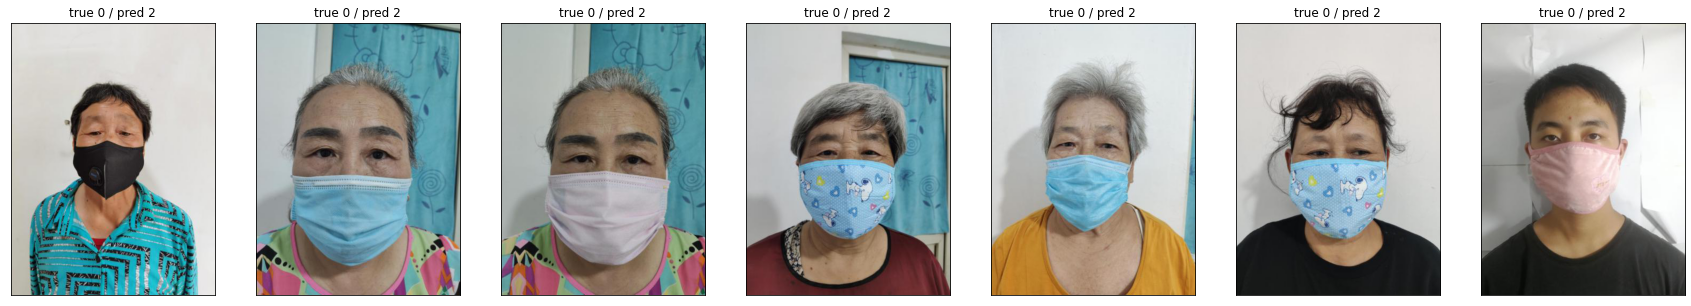

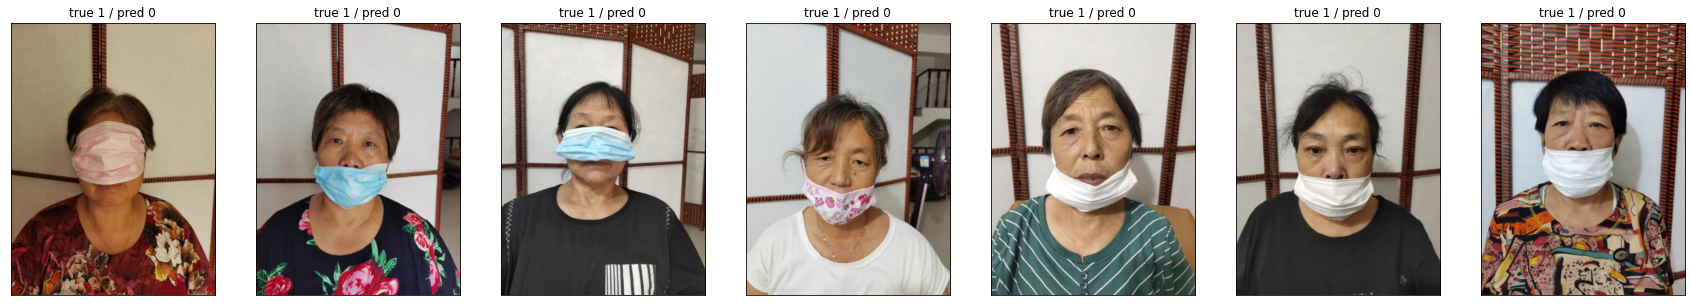

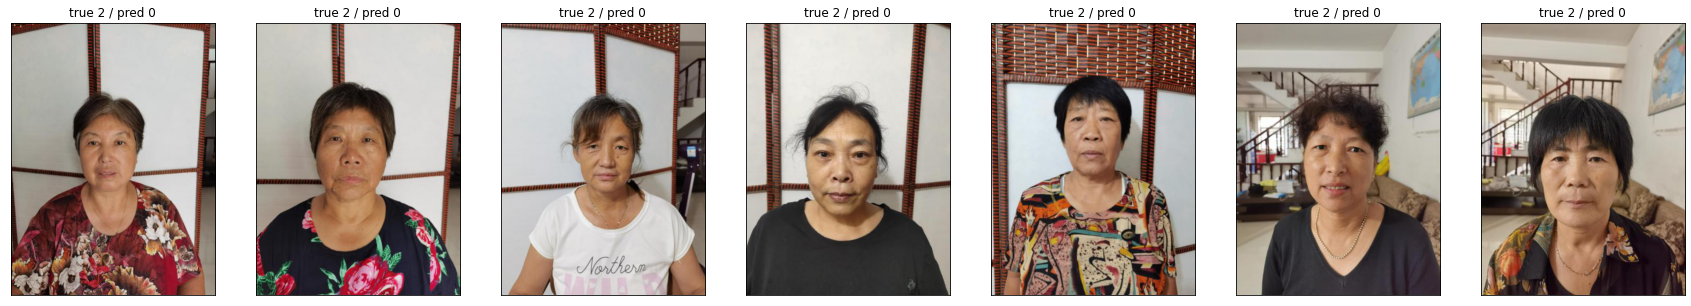

In [34]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.maskModel)

# 5. Gender Model

## 5-1. Mask0

In [23]:
version = 'gender_mask0'

In [25]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 0].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel'
                                                                                       )
    
    # 모델 정의
    model = CreateModel(cfg = config.genderModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.genderModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.genderModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.genderModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 9e-05, train_loss: 0.5232, train_acc: 0.7333, train_f1: 0.6958, val_loss: 0.4650, val_acc: 0.7793, val_fi: 0.7626, 학습시간: 20.32538604736328 

0.7625693210954465 모델 저장
1fold 훈련 시간: 20.596845865249634 

2fold, epoch: 1, lr: 9e-05, train_loss: 0.5271, train_acc: 0.7296, train_f1: 0.6935, val_loss: 0.4066, val_acc: 0.8200, val_fi: 0.8028, 학습시간: 20.29004454612732 

0.8027714800525944 모델 저장
2fold 훈련 시간: 20.581664323806763 

3fold, epoch: 1, lr: 9e-05, train_loss: 0.5331, train_acc: 0.7261, train_f1: 0.6848, val_loss: 0.4427, val_acc: 0.8078, val_fi: 0.7934, 학습시간: 20.2857768535614 

0.7933682914921204 모델 저장
3fold 훈련 시간: 20.46330952644348 

4fold, epoch: 1, lr: 9e-05, train_loss: 0.5255, train_acc: 0.7314, train_f1: 0.6973, val_loss: 0.4787, val_acc: 0.7616, val_fi: 0.7310, 학습시간: 20.14519429206848 

0.7309715646862487 모델 저장
4fold 훈련 시간: 20.3272488117218 

5fold, epoch: 1, lr: 9e-05, train_loss: 0.5331, train_acc: 0.7283, train_f1: 0.6851, val_loss: 0.4252, val_acc: 0.8011, 

In [26]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 0].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel')
    model = CreateModel(cfg = config.genderModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.genderModel.model_dir, f'{version}_{fold_num}fold_{config.genderModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

1fold 훈련 시간: 4.517772912979126, acc: 0.7792975970425139, f1_score: 0.7625693210954465 

2fold 훈련 시간: 4.5931689739227295, acc: 0.82, f1_score: 0.8027714800525944 

3fold 훈련 시간: 4.281898021697998, acc: 0.8077777777777778, f1_score: 0.7933682914921204 

4fold 훈련 시간: 4.2827537059783936, acc: 0.7615526802218114, f1_score: 0.7309715646862487 

5fold 훈련 시간: 4.516655445098877, acc: 0.8011111111111111, f1_score: 0.786111797485534 



In [27]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.7757, train acc: 0.7939 



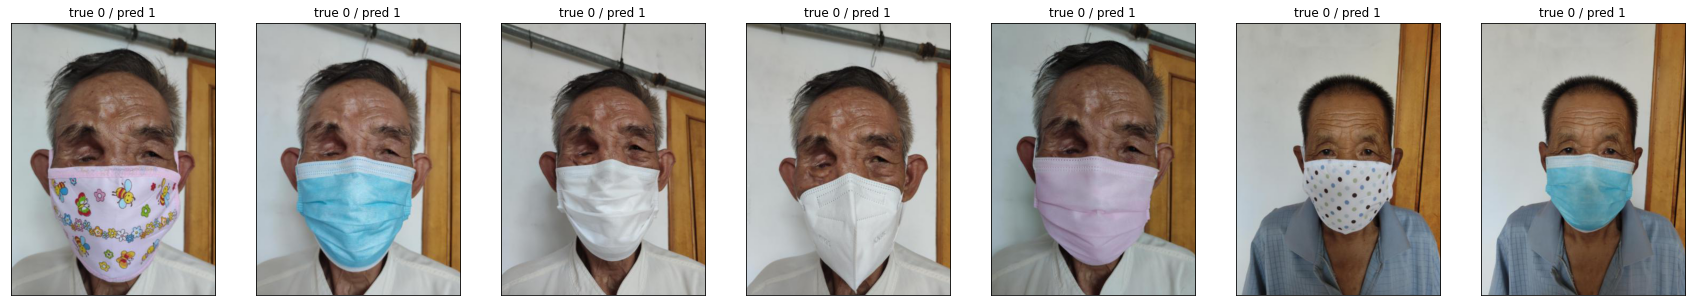

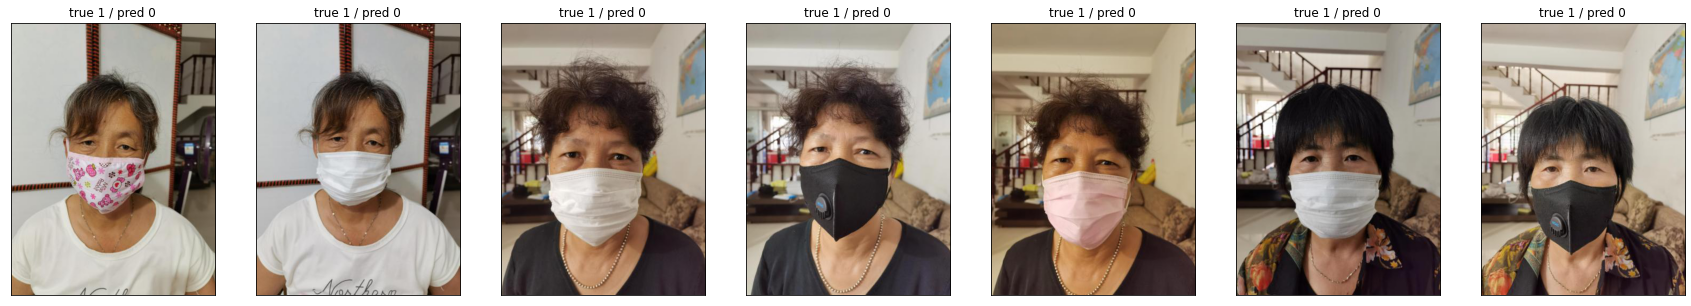

In [30]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.genderModel)

## 5-2. Mask1

In [35]:
version = 'gender_mask1'

In [36]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 1].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel'
                                                                                       )
    
    # 모델 정의
    model = CreateModel(cfg = config.genderModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.genderModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.genderModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.genderModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 9e-05, train_loss: 0.6547, train_acc: 0.6043, train_f1: 0.5055, val_loss: 0.6589, val_acc: 0.6599, val_fi: 0.5525, 학습시간: 5.046308994293213 

0.5525227460711332 모델 저장
1fold 훈련 시간: 5.466094493865967 

2fold, epoch: 1, lr: 9e-05, train_loss: 0.6565, train_acc: 0.6161, train_f1: 0.5723, val_loss: 0.6309, val_acc: 0.6500, val_fi: 0.5200, 학습시간: 5.00818395614624 

0.520031602857425 모델 저장
2fold 훈련 시간: 5.197990417480469 

3fold, epoch: 1, lr: 9e-05, train_loss: 0.6793, train_acc: 0.5643, train_f1: 0.5327, val_loss: 0.6828, val_acc: 0.6352, val_fi: 0.4739, 학습시간: 5.0800535678863525 

0.47388463840078343 모델 저장
3fold 훈련 시간: 5.2565391063690186 

4fold, epoch: 1, lr: 9e-05, train_loss: 0.6625, train_acc: 0.5956, train_f1: 0.5123, val_loss: 0.6879, val_acc: 0.6340, val_fi: 0.4602, 학습시간: 4.974194049835205 

0.460177793904209 모델 저장
4fold 훈련 시간: 5.146134376525879 

5fold, epoch: 1, lr: 9e-05, train_loss: 0.6717, train_acc: 0.5791, train_f1: 0.4913, val_loss: 0.6556, val_acc: 0.6241, 

In [37]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 1].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel')
    model = CreateModel(cfg = config.genderModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.genderModel.model_dir, f'{version}_{fold_num}fold_{config.genderModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

1fold 훈련 시간: 1.5080180168151855, acc: 0.6598890942698706, f1_score: 0.5525227460711332 

2fold 훈련 시간: 1.5311520099639893, acc: 0.65, f1_score: 0.520031602857425 

3fold 훈련 시간: 1.4938175678253174, acc: 0.6351851851851852, f1_score: 0.47388463840078343 

4fold 훈련 시간: 1.4807829856872559, acc: 0.634011090573013, f1_score: 0.460177793904209 

5fold 훈련 시간: 1.540938138961792, acc: 0.6240740740740741, f1_score: 0.4479667631877124 



In [38]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.4933, train acc: 0.6406 



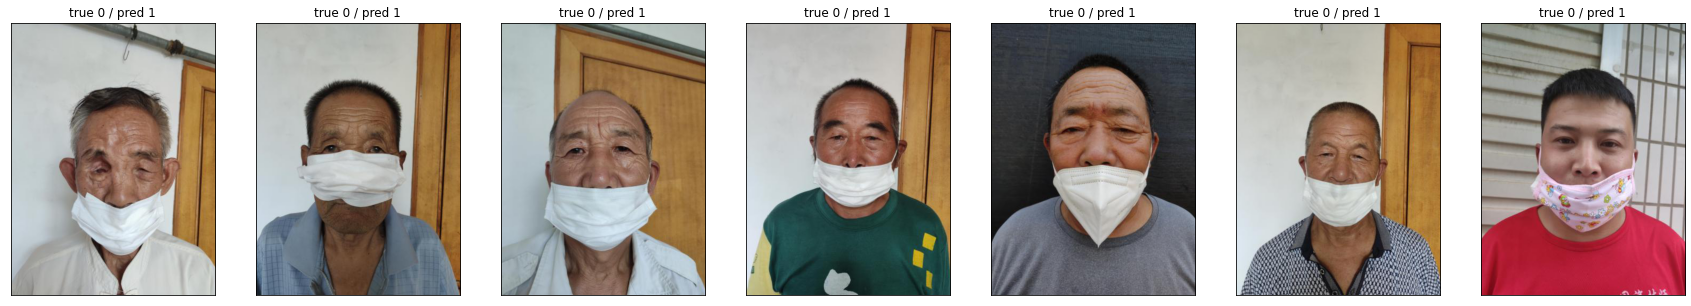

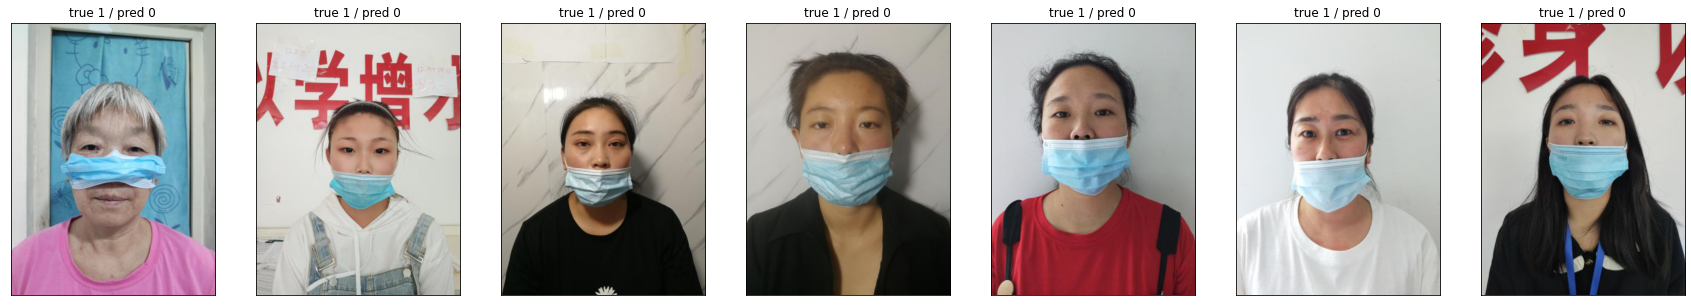

In [39]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.genderModel)

## 5-3. Mask2

In [40]:
version = 'gender_mask2'

In [41]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 2].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.genderModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.genderModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.genderModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.genderModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 9e-05, train_loss: 0.6531, train_acc: 0.6150, train_f1: 0.5558, val_loss: 0.6326, val_acc: 0.6506, val_fi: 0.5519, 학습시간: 4.983396053314209 

0.5518637827887714 모델 저장
1fold 훈련 시간: 5.158474683761597 

2fold, epoch: 1, lr: 9e-05, train_loss: 0.6845, train_acc: 0.5527, train_f1: 0.5224, val_loss: 0.6764, val_acc: 0.6241, val_fi: 0.4610, 학습시간: 5.000129699707031 

0.4610380990309306 모델 저장
2fold 훈련 시간: 5.177881717681885 

3fold, epoch: 1, lr: 9e-05, train_loss: 0.6554, train_acc: 0.5962, train_f1: 0.5184, val_loss: 0.6656, val_acc: 0.6278, val_fi: 0.4784, 학습시간: 5.0103843212127686 

0.4783711955555342 모델 저장
3fold 훈련 시간: 5.181038856506348 

4fold, epoch: 1, lr: 9e-05, train_loss: 0.6471, train_acc: 0.6261, train_f1: 0.5363, val_loss: 0.6759, val_acc: 0.6266, val_fi: 0.4991, 학습시간: 4.9751036167144775 

0.4990557042795849 모델 저장
4fold 훈련 시간: 5.148055553436279 

5fold, epoch: 1, lr: 9e-05, train_loss: 0.6945, train_acc: 0.5389, train_f1: 0.5351, val_loss: 0.6523, val_acc: 0.6500

In [42]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[train_df['masks'] == 2].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.genderModel, 
                                                                                        model_name = 'genderModel')
    model = CreateModel(cfg = config.genderModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.genderModel.model_dir, f'{version}_{fold_num}fold_{config.genderModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

1fold 훈련 시간: 1.512899398803711, acc: 0.6506469500924215, f1_score: 0.5518637827887714 

2fold 훈련 시간: 1.5199565887451172, acc: 0.6240740740740741, f1_score: 0.4610380990309306 

3fold 훈련 시간: 1.4642348289489746, acc: 0.6277777777777778, f1_score: 0.4783711955555342 

4fold 훈련 시간: 1.483989953994751, acc: 0.6266173752310537, f1_score: 0.4990557042795849 

5fold 훈련 시간: 1.5248298645019531, acc: 0.65, f1_score: 0.5011120615911036 



In [43]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.5001, train acc: 0.6358 



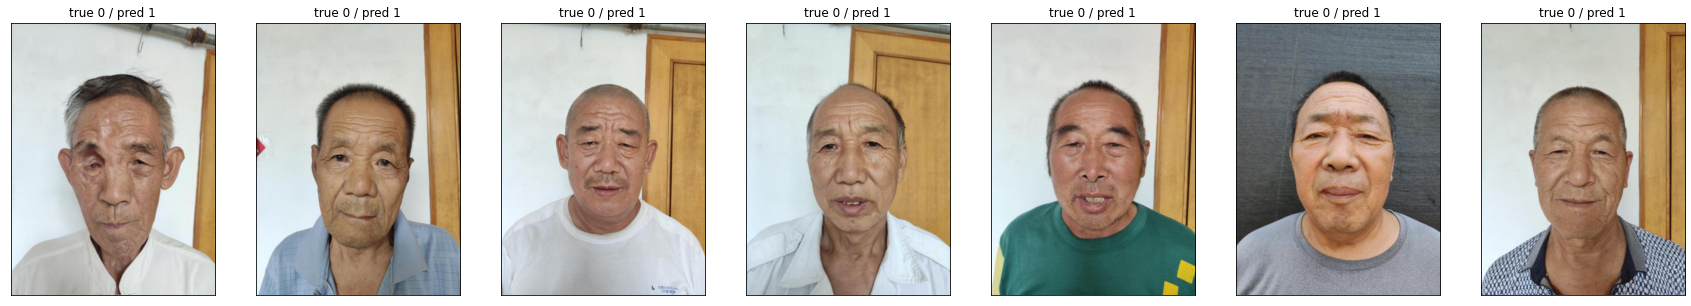

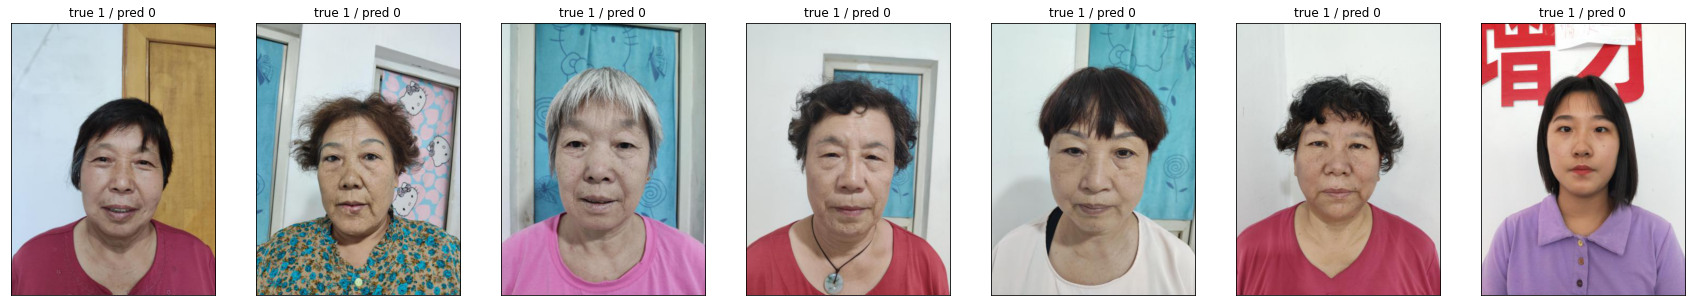

In [44]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.genderModel)

# 6. Age Model

## 6-1. Mask0 - male

In [58]:
version = 'age_mask0_male'

In [59]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 0) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

1fold, epoch: 1, lr: 9e-05, train_loss: 0.9257, train_acc: 0.6125, train_f1: 0.4811, val_loss: 0.7782, val_acc: 0.7400, val_fi: 0.5028, 학습시간: 8.507764101028442 

0.5027626186864956 모델 저장
1fold 훈련 시간: 8.760540008544922 

2fold, epoch: 1, lr: 9e-05, train_loss: 0.8689, train_acc: 0.6849, train_f1: 0.4632, val_loss: 0.7912, val_acc: 0.7407, val_fi: 0.5050, 학습시간: 8.388076543807983 

0.5050472923961788 모델 저장
2fold 훈련 시간: 8.559839248657227 

3fold, epoch: 1, lr: 9e-05, train_loss: 0.8842, train_acc: 0.6717, train_f1: 0.4938, val_loss: 0.7798, val_acc: 0.7356, val_fi: 0.5058, 학습시간: 8.431354522705078 

0.5058169680471839 모델 저장
3fold 훈련 시간: 8.609286069869995 

4fold, epoch: 1, lr: 9e-05, train_loss: 0.8650, train_acc: 0.6923, train_f1: 0.4736, val_loss: 0.7992, val_acc: 0.7589, val_fi: 0.5197, 학습시간: 8.441628217697144 

0.5197368196189012 모델 저장
4fold 훈련 시간: 8.61211609840393 

5fold, epoch: 1, lr: 9e-05, train_loss: 0.8837, train_acc: 0.6658, train_f1: 0.4667, val_loss: 0.8065, val_acc: 0.7627, v

In [60]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 0) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

1fold 훈련 시간: 2.0957767963409424, acc: 0.74, f1_score: 0.5027626186864956 

2fold 훈련 시간: 2.1072161197662354, acc: 0.7406698564593301, f1_score: 0.5050472923961788 

3fold 훈련 시간: 1.9959673881530762, acc: 0.7355769230769231, f1_score: 0.5058169680471839 

4fold 훈련 시간: 2.0632293224334717, acc: 0.7588516746411483, f1_score: 0.5197368196189012 

5fold 훈련 시간: 2.1439483165740967, acc: 0.7626794258373206, f1_score: 0.5219143701395844 



In [61]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.5112, train acc: 0.7476 



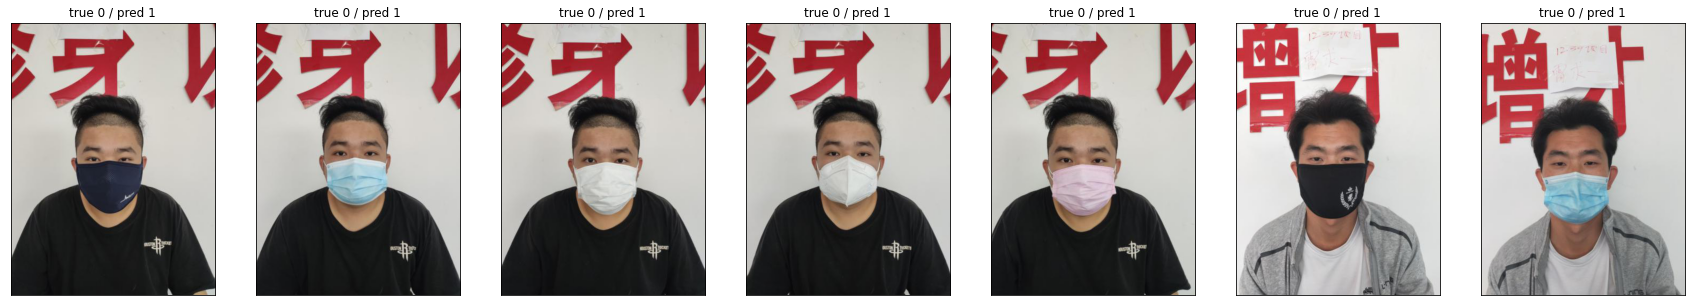

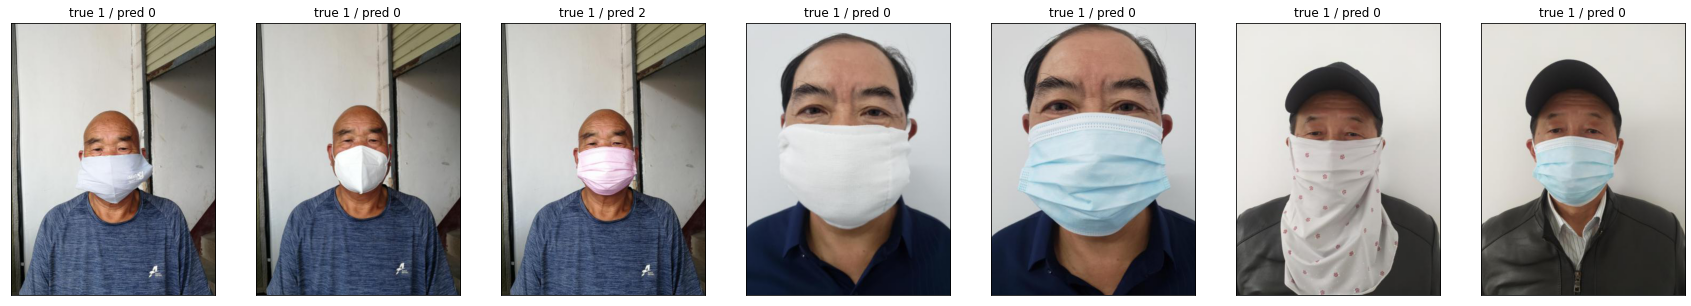

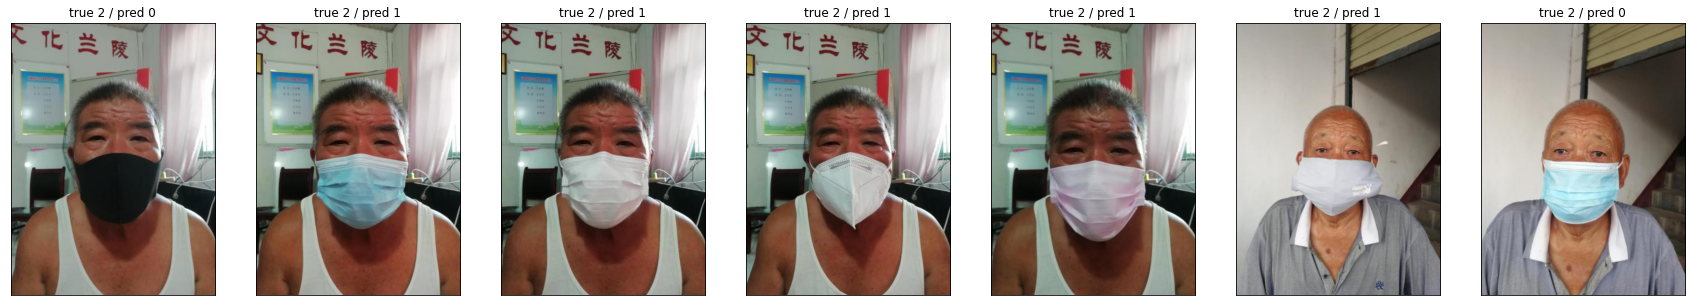

In [62]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

## 6-2. Mask1 - male

In [63]:
version = 'age_mask1_male'

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 1) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 1) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

In [ ]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

In [ ]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

## 6-3. Mask2 - male

In [ ]:
version = 'age_mask2_male'

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 2) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 2) & (train_df['genders'] == 0)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

In [ ]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

In [ ]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

## 6-4. Mask0 - female

In [ ]:
version = 'age_mask0_female'

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 0) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 0) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

In [ ]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

In [ ]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

## 6-5. Mask1 - female

In [ ]:
version = 'age_mask1_female'

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 1) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 1) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

In [ ]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

In [ ]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

## 6-6. Mask2 - female

In [ ]:
version = 'age_mask2_female'

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 2) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    
    # 모델 정의
    model = CreateModel(cfg = config.ageModel, pretrained = True).to(device)
    criterion = get_criterion(config = config.ageModel)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.ageModel.lr, amsgrad = True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 3)
    
    train(model = model,
          optimizer = optimizer, 
          criterion = criterion, 
          train_loader = train_loader, 
          val_loader = val_loader, 
          scheduler = scheduler, 
          config = config.ageModel,
         version = version)
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

In [ ]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)
train_df = train_df[(train_df['masks'] == 2) & (train_df['genders'] == 1)].reset_index(drop = True)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.data_split_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[list(set(val_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_df = train_df.set_index('id').loc[list(set(trn_id_df['id'].tolist()) & set(train_df['id'].tolist())), :].reset_index(drop = True)
    
    trn_dataset, train_loader, val_dataset, val_loader = get_trn_val_dataset_dataloader(trn_df = trn_df, 
                                                                                        val_df = val_df, 
                                                                                        cfg = config.ageModel, 
                                                                                        model_name = 'ageModel')
    model = CreateModel(cfg = config.ageModel, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.ageModel.model_dir, f'{version}_{fold_num}fold_{config.ageModel.model_name}.pt')))
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loader)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    fold_end_time = time.time()
    
    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

In [ ]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

In [ ]:
get_eval_img_show(train_df = train_df, idx_li = idx_li, pred_labels = pred_labels, config = config.ageModel)

# 7. Ensemble